# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [8]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
%matplotlib inline

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [9]:
# Read the Mapbox API key
mapbox_token = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [10]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [11]:
# Housing Units Per Year
new_df = sfo_data.groupby('year').mean()
year_units = new_df.drop(columns = ["sale_price_sqr_foot", "gross_rent"])

# Average Gross Rent
rent_sale = sfo_data.drop(columns = ["neighborhood", "housing_units", "sale_price_sqr_foot"])
rent_mean = rent_sale.groupby(["year"]).mean()

# Average Sale Price
rent_sale = sfo_data.drop(columns = ["neighborhood", "housing_units", "gross_rent"])
sale_mean = rent_sale.groupby(["year"]).mean()

# Average Price by Neighborhood
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
hood_df = pd.read_csv(file_path, index_col="year")
neighborhood1 = hood_df.groupby(["year", "neighborhood"]).mean()

# Top 10 Most Expensive
neighborhoods = neighborhood1.groupby("neighborhood").mean()
neighborhoods1 = neighborhoods.drop(columns = ["housing_units", "gross_rent"])
neighborhood_rank = neighborhoods.sort_values(by='sale_price_sqr_foot', ascending=False)
neighborhood_rank.reset_index(inplace=True)
top10 = neighborhood_rank.head(10)
Top1 = top10.drop(columns = ["housing_units", "gross_rent"])

# Parallel Coordinates
px.parallel_coordinates(top10, color='sale_price_sqr_foot')

# Parallel Categories
px.parallel_categories(
    top10.round(2),
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "gross_rent": "Gross Rent",
        "sale_price_sqr_foot": "Square Foot Price",
        "housing_units": "Unit Number",
    },
)

# Neighborhood Map
n = neighborhood_rank.drop(columns= (["housing_units", "gross_rent"]))
mean_values = n.groupby(["neighborhood"]).mean()
neighborhood_df = df_neighborhood_locations.drop(columns = "Neighborhood")
df_neighborhood_locations1 = pd.concat([mean_values, neighborhood_df], join = "inner", axis = "columns")
# px.scatter_mapbox(df_neighborhood_locations, title = "Average Sale Price Per Square Foot and Gross Rent In San Fransisco", lat="Lat", lon="Lon",  color="Neighborhood")

In [12]:
# Define Panel Visualization Functions

def housing_units_per_year():
    # fig_housing_units = plt.figure(figsize=((10,2)))
    housing_units = year_units.hvplot.bar(
        ylim = (370000, 385000),
        y="housing_units",
        title="Housing Units Per Year")
    # plt.close(fig_housing_units)
    return housing_units
    


def average_gross_rent():
    # fig_rent_avg = plt.figure(figsize=((10,2)))
    rent_avg = rent_mean.hvplot.line(
        y="gross_rent",
        title="Average Gross Rent in San Francisco Per Year") 
    # plt.close(fig_rent_avg)
    return rent_avg
    


def average_sales_price():
    # fig_sale_avg = plt.figure(figsize=((10,2)))
    sale_avg = sale_mean.hvplot.line(
        y="sale_price_sqr_foot",
        title="Average Sales Price Per Year")
    # plt.close(fig_sale_avg)
    return sale_avg
    

def average_price_by_neighborhood():
    # fig_avg_hood_price = plt.figure()
    avg_hood_price = neighborhood1.hvplot.line(#"year", "sale_price_sqr_foot", 
        groupby = "neighborhood",
        y="sale_price_sqr_foot",
        title="Average Sales Price Per Year")
    # plt.close(fig_avg_hood_price)
    return avg_hood_price



def top_most_expensive_neighborhoods():
    # fig_top10_expensive =plt.figure()
    top10_expensive = Top1.hvplot.bar(
        x="neighborhood",
        ylim=(500,900),
        # y="sale_price_sqr_foot",
        title="Top 10 Most Expensive Neighborhoods")
    # plt.close(fig_top10_expensive)
    return top10_expensive



def parallel_coordinates():
    # fig_p_coord = plt.figure(figsize=((10,2)))
    p_coord = px.parallel_coordinates(
    top10.round(2),
    color='sale_price_sqr_foot',
    title = "Parallel Plot")
    # plt.close(fig_p_coord)
    return p_coord


def parallel_categories():
    # fig_p_cat = plt.figure(figsize=((10,2)))
    p_cat = px.parallel_categories(
    top10.round(2),
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "gross_rent": "Gross Rent",
        "sale_price_sqr_foot": "Square Foot Price",
        "housing_units": "Unit Number"
    },
)
    # plt.close(fig_p_cat)
    return p_cat
    


def neighborhood_map():
    # fig_neighborhood_locations = plt.figure()
    px.set_mapbox_access_token(mapbox_token)
    neighborhood_locations = px.scatter_mapbox(
        df_neighborhood_locations,
        lat="Lat",
        lon="Lon",
        color="Neighborhood",
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average Sale Price Per Square Foot and Gross Rent In San Fransisco",
        zoom=3,
        width=1000)
    # plt.close(fig_neighborhood_locations)
    return neighborhood_locations


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [15]:
housing_per_year = pn.Column(
    "## Housing Units Per Year",
    housing_units_per_year,
    "##Average Gross Rent Per Year",
    average_gross_rent,
    "## Average Sale Price Per Year",
    average_sales_price
)

avg_neighborhood_prices = pn.Column(
    "## Average Prices by Neighborhood",
    average_price_by_neighborhood,
    "## Most Expensive Neighborhoods",
    top_most_expensive_neighborhoods
)

parallel_co = pn.Column(
    "## Parallel Coordinates Plot",
    parallel_coordinates,
    "## Parellel Categories Plot",
    parallel_categories
)

neighborhood_fig = neighborhood_map()

neighborhood_map1 = pn.Column(
    "## Neighborhood Map",
    neighborhood_fig
)


dashboard = pn.Tabs(
    ("Welcome", neighborhood_map1),
    ("Yearly Market Analysis", housing_per_year),
    ("Neighborhood Analysis", avg_neighborhood_prices),
    ("Parallel Plot Analysis",parallel_co)
    
)

In [16]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Bars, name='interactive03490')
        [2] Markdown(str)
        [3] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Curve, name='interactive03560')
        [4] Markdown(str)
        [5] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Curve, name='interactive03630')
    [2] Column
        [0] Markdown(str)
        [1] Column
            [0] Column()
            [1] Row
                [0] Row(name='interactive03701')
                    [0] HoloViews(DynamicMap, name='interactive03701')
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                        [1] VSpacer()
        [2] Markdown(str)
        [3] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Bars, name='interactive03747')
    [3] Column
        [0] Markdown(str)
        [1] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive03818')
        [2] Markdown(str)
        [3] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive03826')

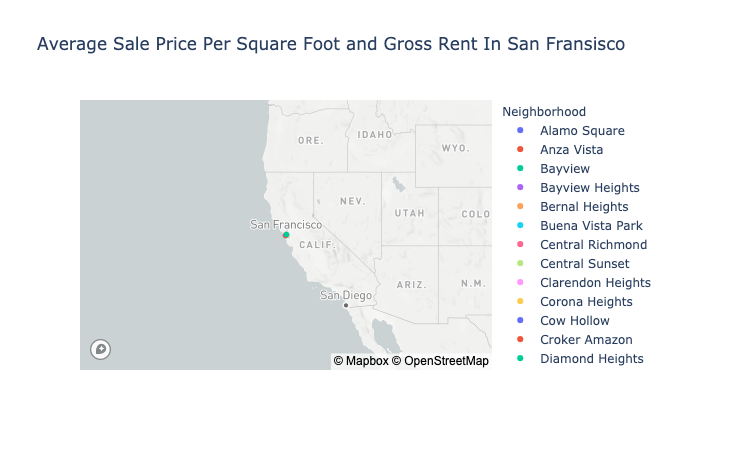

In [17]:
# Neighborhood Map will Plot (Tabs are not working correctly)
neighborhood_map()

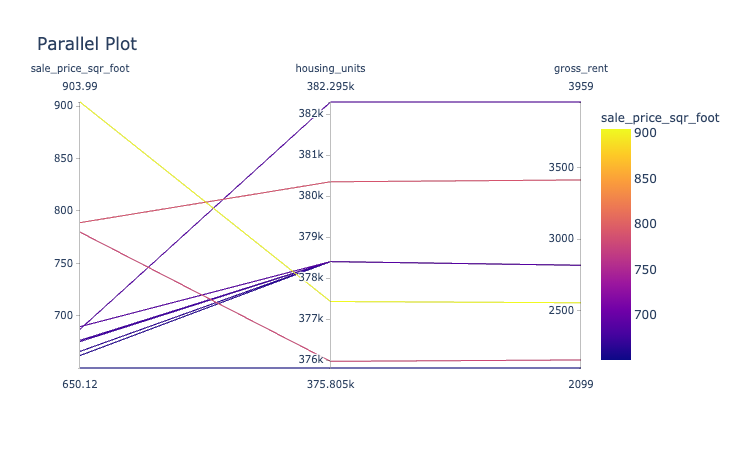

In [18]:
# Parallel Coordinates will Plot
parallel_coordinates()

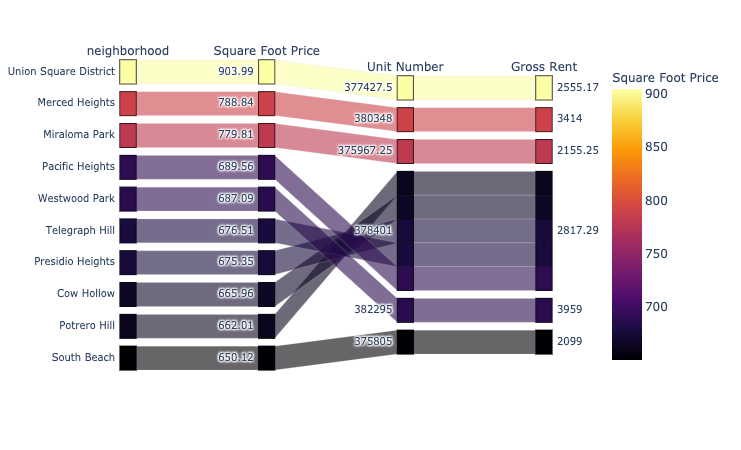

In [19]:
# Parallel Categories will Plot
parallel_categories()